# Merit order evaluation
Create an merit order block from input data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
input_folder = './model_inputs/'
transformers = pd.read_csv(input_folder+'transformers_2017.csv')
transformers = transformers.loc[transformers['country'] == 'DE', ['label', 'fuel', 'capacity', 'efficiency_el']]

In [3]:
# fuel costs
costs_fuel = pd.read_csv(input_folder+'costs_fuel_NZE_nominal_2017.csv')
costs_fuel['fuel'] = [_[2] for _ in costs_fuel['label'].str.split('_')]
costs_fuel = costs_fuel.loc[costs_fuel['label'].str.contains('DE'), ['fuel', '2017']]
costs_fuel.rename(columns={'2017': 'costs_fuel'}, inplace=True)

# operation costs
costs_opex = pd.read_csv(input_folder+'costs_operation_nominal_2017.csv')
costs_opex['fuel'] = [_[2] for _ in costs_opex['label'].str.split('_')]
costs_opex = costs_opex.loc[costs_opex['label'].str.contains('DE'), ['fuel', '2017']]
costs_opex.rename(columns={'2017': 'costs_opex'}, inplace=True)

# emission factors
sources_commodity = pd.read_csv(input_folder+'sources_commodity_2017.csv')
sources_commodity['fuel'] = [_[2] for _ in sources_commodity['label'].str.split('_')]
sources_commodity = sources_commodity.loc[sources_commodity['label'].str.contains('DE'), ['fuel', 'emission_factors']]

In [4]:
transformers = transformers.merge(costs_fuel, on='fuel', how='left')
transformers = transformers.merge(costs_opex, on='fuel', how='left')
transformers = transformers.merge(sources_commodity, on='fuel', how='left')
carbon_price = 5.77
transformers['carbon_price'] = carbon_price
transformers['costs_carbon'] = transformers['emission_factors'] * transformers['carbon_price']

In [5]:
# renewables time series
time = '2017-08-05 13:00:00'
sources_res_ts = pd.read_csv(input_folder+'sources_renewables_ts_2017.csv', index_col=0)
sources_res_ts = sources_res_ts[sources_res_ts.columns[sources_res_ts.columns.str.contains('DE')]]
sources_res_ts = sources_res_ts.loc[time]
sources_res_ts = sources_res_ts.to_frame()
sources_res_ts.columns = ['capacity_factor']

In [6]:
#sources_res_ts.loc['2017-08-05 00:00:00' : '2017-08-06 00:00:00']

In [7]:
# non-fluc renewables
sources_res = pd.read_csv(input_folder+'sources_renewables_2017.csv', usecols=['label', 'capacity', 'country'])
sources_res['fuel'] = [_[2] for _ in sources_res['label'].str.split('_')]
sources_res = sources_res.merge(sources_res_ts, left_on='label', right_index=True, how='left')
sources_res['capacity'] *= sources_res['capacity_factor']
sources_res = sources_res.loc[sources_res['country'] == 'DE', ['fuel', 'capacity']]
sources_res.replace({'ROR': 'Wasser', 'Klaergas': 'Klärgas'}, inplace=True)
sources_res['costs_fuel'] = 0
sources_res['efficiency_el'] = 1
sources_res['label'] = sources_res['fuel']

In [9]:
# reneweable transformers
transformers_res = pd.read_csv(input_folder+'transformers_renewables_2017.csv')

# operation costs
costs_res = pd.read_csv(input_folder+'costs_operation_renewables_2017.csv')
transformers_res = transformers_res.merge(costs_res, on='label', how='left')

transformers_res = transformers_res.merge(sources_res_ts, left_on='from', right_index=True, how='left')
transformers_res['capacity'] *= transformers_res['capacity_factor']

transformers_res['fuel'] = [_[1] for _ in transformers_res['label'].str.split('_')]

# market values renewables
costs_market_values = pd.read_csv(input_folder+'costs_market_values_2017.csv', index_col=0)
costs_market_values = costs_market_values.loc[time].to_frame()
costs_market_values.columns = ['market_values']
transformers_res = transformers_res.merge(costs_market_values, right_index=True, left_on='from', how='left')

# derive costs renewable transformers
transformers_res['costs_fuel'] = transformers_res['costs']+transformers_res['market_values']
exog_trafos = ['DE_solarPV_cluster_exogenous', 'DE_windoffshore_cluster_exogenous', 'DE_windonshore_cluster_exogenous']
transformers_res.loc[transformers_res['label'].isin(exog_trafos), 'costs_fuel'] = 0

transformers_res = transformers_res[['label', 'fuel', 'efficiency_el', 'capacity', 'costs_fuel']]

In [10]:
### Merge
blocks = pd.concat([transformers, sources_res, transformers_res]).fillna(0)

# derive marginal costs
blocks['costs_marginal'] = blocks["costs_opex"] +\
(blocks["costs_fuel"] + blocks["costs_carbon"]) / (blocks['efficiency_el'])

# derive cumulated capacity
blocks = blocks.sort_values(by='costs_marginal', ascending=True)
blocks["capacity_cumulated"] = blocks["capacity"].cumsum()

# assign symbolic euro for illustration purposes
blocks.loc[blocks['costs_marginal'] == 0, 'costs_marginal'] = 4

In [11]:
blocks["fuel"].unique()

array(['solarPV', 'windoffshore', 'windonshore', 'Wasser', 'landfillgas',
       'biomassEEG', 'geothermal', 'larga', 'minegas', 'waste', 'uranium',
       'lignite', 'natgas', 'otherfossil', 'hardcoal', 'oil',
       'mixedfuels', 'biomass'], dtype=object)

In [15]:
fuel_dict = {
    'solarPV': 'Solare Strahlungsenergie',
    'windonshore': 'Windenergie an Land',
    'windoffshore': 'Windenergie auf See',
    'uranium': 'Kernenergie',
    'lignite': 'Braunkohle',
    'otherfossil': 'Andere fossile',
    'hardcoal': 'Steinkohle',
    'waste': 'Abfall',
    'mixedfuels': 'Mehrere fossile',
    'biomass': 'Biomasse',
    'biomassEEG': 'Biomasse',
    'landfillgas': 'Deponiegas',
    'geothermal': 'Geothermie',
    'minegas': 'Grubengas',
    'larga': 'Klärgas',
    'natgas': 'Erdgas',
    'oil': 'Heizöl'
}
blocks['fuel'].replace(fuel_dict, inplace=True)

In [16]:
# 28.07.2019 YW: assign a color to each fuel for better identification in the Merit Order graph
colorcomb = {
    'Solare Strahlungsenergie': '#fcb001',#'#fac205',#'#ffff14',
    'Windenergie auf See': '#0504aa',
    'Windenergie an Land': '#82cafc',#'#95d0fc',
    'Biomasse': '#15b01a',
    'Deponiegas': '#06c2ac',
    'Geothermie': '#ff474c',
    'Wasser': '#c79fef', 
    'Grubengas': '#650021', 
    'Klärgas': '#ad8150', 
    'Kernenergie': '#e50000',
    'Braunkohle': '#7f2b0a',
    'Andere fossile': '#d8dcd6',
    'Steinkohle': '#000000', 
    'Abfall': '#c04e01',
    'Mehrere fossile': '#a57e52',
    'Erdgas': '#929591', 
    'Heizöl': '#aaa662'
}

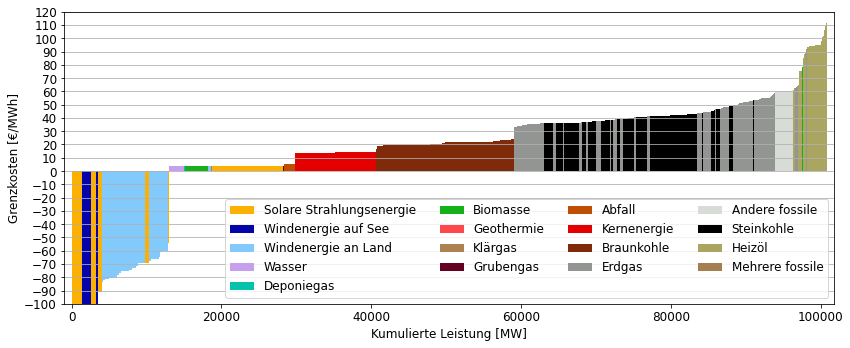

In [17]:
matrix = blocks[['fuel', 'costs_marginal', 'capacity_cumulated']].values
MeritOrder = np.zeros((0,3))
for el in range(len(matrix)-1):
    MeritOrder = np.append(MeritOrder, np.reshape(matrix[el,], (1,3)), axis=0)
    if matrix[el,0] != matrix[el+1,0]:
        obj = np.reshape(matrix[el,], (1,3))
        obj[0][0] = matrix[el+1,0]
        MeritOrder = np.append(MeritOrder, obj, axis=0)

# 28.07.2019 YW: creation of pd.Dataframe to have better access within the plot function
MeritOrder = pd.DataFrame(data=MeritOrder, columns=['fuel', 'costs_marginal', 'capacity_cumulated'])
MeritOrder = MeritOrder.astype({'capacity_cumulated': 'float32', 'costs_marginal': 'float32'})

plt.rcParams.update({'font.size': 12})
# 28.07.2019 YW: creates the Merit-Order plot of the given PP portfolio
fig, ax = plt.subplots(figsize = (12,5))
for fuel in MeritOrder['fuel'].unique():
    _ = ax.fill_between(x='capacity_cumulated',
                        y1='costs_marginal',
                        where = MeritOrder["fuel"] == fuel,
                        facecolor = colorcomb[fuel],
                        step = "pre",
                        lw = 15,
                        #        interpolate = True,
                        data = MeritOrder,
                        label=fuel)
_ = ax.set(xlim=(-1000, MeritOrder['capacity_cumulated'].max() + 1000),
#            ylim=(MeritOrder['costs_marginal'].min() - 10, MeritOrder['costs_marginal'].max() + 10))
           ylim=(-100, 120)
          )
_ = ax.grid(axis="y")
_ = plt.yticks(np.arange(-100, 121, 10.0))
_ = plt.xlabel('Kumulierte Leistung [MW]')
_ = plt.ylabel('Grenzkosten [€/MWh]')
_ = ax.legend(loc='lower right', ncol=4)

plt.tight_layout()

plt.show()

In [18]:
MeritOrder

,fuel,costs_marginal,capacity_cumulated
0,Solare Strahlungsenergie,-523.583923,0.768393
1,Solare Strahlungsenergie,-497.343933,2.849832
2,Solare Strahlungsenergie,-470.093933,6.598341
3,Solare Strahlungsenergie,-443.343933,20.841949
4,Solare Strahlungsenergie,-422.473938,38.497482
...,...,...,...
707,Heizöl,109.102928,100664.250000
708,Heizöl,110.008598,100741.648438
709,Heizöl,110.008598,100775.648438
710,Heizöl,111.649399,100798.945312
